In [66]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import math
import os 
import torch.nn.functional as F

import importlib
import data_analysis
importlib.reload(data_analysis)

import utils
importlib.reload(utils)

%matplotlib inline
matplotlib.pyplot.rc('text', usetex=True)

print(f'Working in {os.getcwd()}')

Working in /projects/IceDynamics/Stage_M2/code


In [2]:
from utils import get_freer_gpu

device = get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 22659 MB free memory 


In [3]:
class SimuDataset(Dataset):

    def __init__(self, simu, rgb = False, transform = None):
        X = simu.X
        if rgb : 
            X = simu.X_rgb
        self.x = torch.from_numpy(X).to(device)
        self.n_snapshots = X.shape[1]
        self.transform = transform
        self.rgb = rgb
        
    def __getitem__(self, index):
        sample = self.x[:,index]
        t = index
        
        if self.transform:
            sample = self.transform(sample)
        if self.rgb:
            sample = self.x[:,index, :, :]
        return sample, t 
    
    def __len__(self):
        return self.n_snapshots
    

class LinearAutoencoder(nn.Module):
    def __init__(self, n_channels, N):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels*N, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 12*16))
        
        self.decoder = nn.Sequential(
            nn.Linear(12*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, n_channels*N),
            nn.Tanh())
        
    def forward(self, x):
        # print(f'size of x {x.shape}')
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [4]:
from data_analysis import Simulation
from data_analysis import compatible_path
current_directory = compatible_path('../')

simulation = Simulation(current_directory, normalize = True)
time, x, z, u, w, T, umean, wmean, Tmean = map(lambda x: torch.tensor(x).to(device), simulation.import_data())
simulation.image_rgb()

h, l = np.shape(x)
m = len(time)
print(m)
N = h*l*3

6249


# Simple Linear Autoencoder

## Running algo

In [23]:
class SimpleLinearAutoencoder(nn.Module):
    def __init__(self, N, K = 20, device = device):
        super().__init__()
        self.encoder = nn.Linear(N, K).to(device)
        
        self.decoder = nn.Sequential(
            nn.Linear(K, N), 
            nn.Tanh()).to(device)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
batch_size = 4
K = 20

dataset = SimuDataset(simulation)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(t)
print(torch.min(data), torch.max(data), data.shape)

model = SimpleLinearAutoencoder(N, K, device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor([ 481,  688, 4082, 5203])
tensor(-0.7133, device='cuda:0', dtype=torch.float64) tensor(0.7103, device='cuda:0', dtype=torch.float64) torch.Size([4, 12393])


In [25]:
num_epoch = 9
output = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    output.append((epoch, int(t),  map, reconstructed))

Epoch: 1, Loss: 0.0100
Epoch: 2, Loss: 0.0033
Epoch: 3, Loss: 0.0120
Epoch: 4, Loss: 0.0033
Epoch: 5, Loss: 0.0060
Epoch: 6, Loss: 0.0042
Epoch: 7, Loss: 0.0071
Epoch: 8, Loss: 0.0049
Epoch: 9, Loss: 0.0075


#### saving

In [26]:
torch.save(model.state_dict(), f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

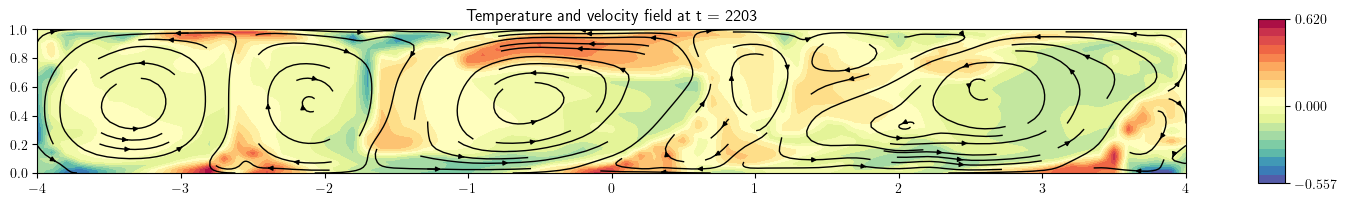

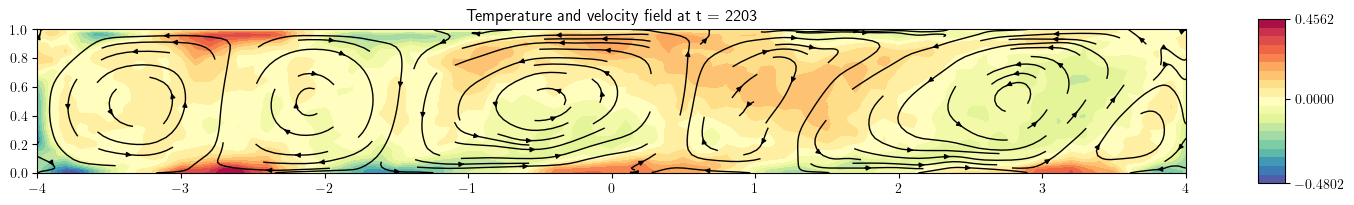

In [27]:
from utils import plot_field
epoch = 8

t = output[epoch][1]
field = np.reshape(np.array(output[epoch][2].cpu()), N)
reconstructed = output[epoch][3].cpu()
reconstructed = np.reshape(reconstructed.detach().numpy(), N)

plot_field(simulation, np.reshape(field[:h*l], (h, l)), np.reshape(field[h*l:2*h*l], (h,l)), np.reshape(field[2*h*l:], (h, l)), t)
plot_field(simulation, np.reshape(reconstructed[:h*l], (h, l)), np.reshape(reconstructed[h*l:2*h*l], (h,l)), np.reshape(reconstructed[2*h*l:], (h, l)), t)

## Analysis

In [20]:
K = 20
encoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/encoder.pt')
decoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/decoder.pt')
model = torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

In [9]:
weights = encoder.cpu().weight.data
U = weights.numpy()

# weights_R = model.decoder.cpu().weight
# R = weights_R.numpy()
print(U.shape)

(20, 12393)


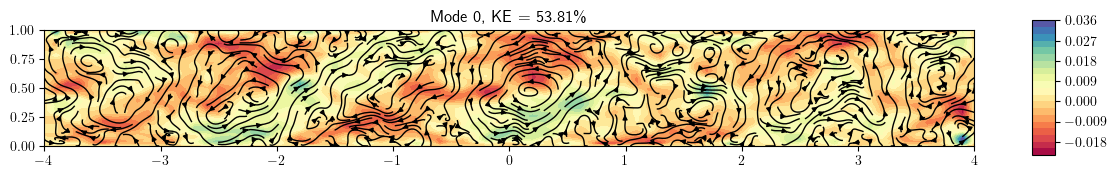

In [28]:
n_mode = 0

KE = np.sum(U, axis = 1)/np.sum(U)
sorting_indexes = np.argsort(KE)[::-1]

u_modes = np.reshape(np.swapaxes(U[:,:h*l], 0,1), (h, l, K))[:,:,sorting_indexes]
w_modes = np.reshape(np.swapaxes(U[:,h*l:2*h*l], 0, 1), (h, l, K))[:,:,sorting_indexes]
T_modes = np.reshape(np.swapaxes(U[:,2*h*l:], 0, 1), (h, l, K))[:,:,sorting_indexes]

from POD import streamplot_mode

streamplot_mode(u_modes, w_modes, u_modes, KE[sorting_indexes], n_mode, simulation.x, simulation.z)

In [32]:
X = simulation.X.T
x = torch.from_numpy(X)
x = x.float()
print(x.shape)
print(x.T.shape)
print(x[0].shape)

torch.Size([6249, 12393])
torch.Size([12393, 6249])
torch.Size([12393])


In [33]:
K = 20  
autoencoder = SimpleLinearAutoencoder(N, K, device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

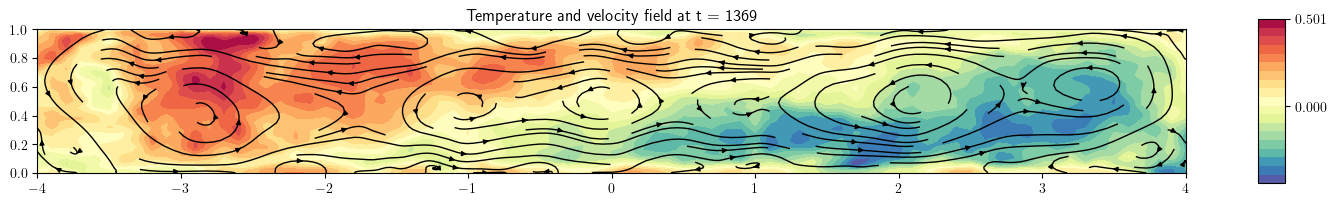

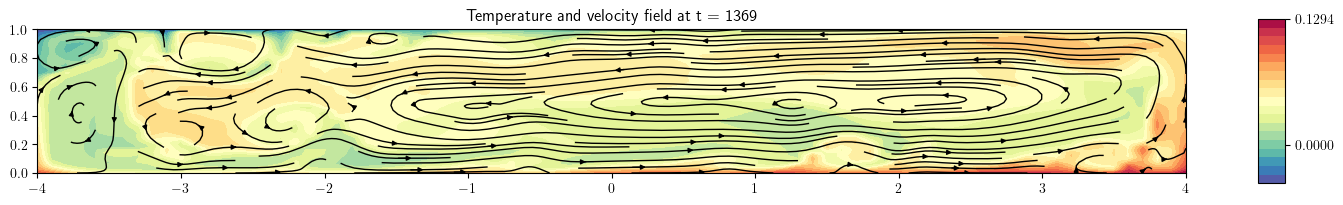

In [58]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy())

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [60]:
decoded_simulation.save_clip(1350, 1400, f'{current_directory}/results/autoencoder/simple_linear/snapshots/')

In [68]:
from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/simple_linear/snapshots/', f'{current_directory}/results/autoencoder/simple_linear/snapshots/linear_ae_decoded_field.gif', 10)

GIF created at: ..//results/autoencoder/simple_linear/snapshots/linear_ae_decoded_field.gif


# Convolutionnal

In [16]:
3*81*51

12393

In [27]:
8 * 27 * 17

3672

In [29]:
24/3

8.0

In [115]:
import torch.nn.functional as F
size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)

class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, n_channels = 64, kernel_size = 3, stride = 1, padding = 1):
        super().__init__()
        #shape : B * 3 * 81 * 51
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n_channels//2, kernel_size, stride = stride, padding = padding), 
            nn.ReLU(), 
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding),
            nn.ReLU(),
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding), 
            nn.Upsample(size=size3, mode='bilinear', align_corners=False)).to(device)
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, n_channels//2, kernel_size, stride = stride, padding = padding), 
            nn.ReLU(), 
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding),
            nn.ReLU(),
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding), 
            nn.Upsample(size=(81, 51), mode='bilinear', align_corners=False)).to(device)
        
        
    def forward(self, x):
        print(f'size of x {x.shape}')
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [117]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [118]:
num_epoch = 9
output = []
for epoch in range(num_epoch):
    for map in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    output.append((epoch, map, reconstructed))

size of x torch.Size([4, 3, 81, 51])


RuntimeError: Given transposed=1, weight of size [3, 32, 3, 3], expected input[4, 64, 3, 2] to have 3 channels, but got 64 channels instead

In [21]:
print(np.shape(simulation.X_rgb))

(3, 6249, 81, 51)


In [23]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [59]:
import torch.nn.functional as F
class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, kernel_size = 3, stride = 1, padding = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride = stride).to(device) 
        self.conv2 = nn.Conv2d(6, 12, 5).to(device) 
        self.conv3 = nn.Conv2d(12, 28, 5).to(device) 

    def forward(self, x):
        x = self.conv1(x)
        print('Shape after conv1:', x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        print('Shape after conv2:', x.shape)
        x = F.relu(x)
        x = self.conv3(x)
        print('Shape after conv3:', x.shape)
        return x

In [107]:
81*51*3

12393

In [112]:
64*20*12

15360

In [114]:
import torch.nn.functional as F

kernel_size = 3
stride = 1
padding = 1

size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)
n_channels = 64

conv1 = nn.Conv2d(3, n_channels//2, kernel_size, stride = 1, padding = 1).to(device) 
conv2 = nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = 1, padding = 1).to(device) 
conv3 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv2 = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv3 = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)


x = conv1(data.float()).to(device)

x = F.relu(x)
x = F.interpolate(x, size = size1)
print('Shape after conv1:', x.shape)
x = conv2(x)

x = F.relu(x)
x = F.interpolate(x, size = size2)
print('Shape after conv2:', x.shape)
x = conv3(x)
x = F.interpolate(x, size = size3)
print('Shape after conv3:', x.shape)

x = conv_inv(x)
x = F.interpolate(x, size = size2)
print('Shape after conv_inv1:', x.shape)
x = F.relu(x)
x = conv_inv2(x)
x = F.interpolate(x, size = size1)
print('Shape after conv_inv2:', x.shape)
x = F.relu(x)
x = conv_inv3(x)
x = F.interpolate(x, size = (81,51))
print('Shape after conv_inv3:', x.shape)

Shape after conv1: torch.Size([4, 32, 20, 12])
Shape after conv2: torch.Size([4, 64, 10, 6])
Shape after conv3: torch.Size([4, 64, 3, 2])
Shape after conv_inv1: torch.Size([4, 64, 10, 6])
Shape after conv_inv2: torch.Size([4, 64, 20, 12])
Shape after conv_inv3: torch.Size([4, 64, 81, 51])


In [72]:
batch_size = 4
n_channels = 3


dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)
model = ConvolutionalAutoencoder(batch_size, n_channels, N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.7316, dtype=torch.float64) tensor(0.7301, dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [49]:
print(np.shape(simulation.X_rgb))
print(np.shape(simulation.u))
print(4*3*81*51)
print(4*6*40*25)

(3, 6249, 81, 51)
(6249, 81, 51)
49572
24000


In [63]:
num_epoch = 1
output = []
for epoch in range(num_epoch):
    for map in dataloader:
        map = map.float()
        print(f'map shape : {map.shape}')
        reconstructed = model(map)
        print(f'reconstructed shape : {reconstructed.shape}')
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    output.append((epoch, map, reconstructed))

map shape : torch.Size([4, 3, 81, 51])
Shape after conv1: torch.Size([4, 6, 40, 25])
Shape after conv2: torch.Size([4, 12, 19, 12])
Shape after conv3: torch.Size([4, 28, 15, 8])
reconstructed shape : torch.Size([4, 28, 15, 8])


/home/julielimonet/Documents/Stage_M2/code/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 3, 81, 51])) that is different to the input size (torch.Size([4, 28, 15, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (8) must match the size of tensor b (51) at non-singleton dimension 3